# Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import enchant
import process # Một module tự tạo dùng để xử lý văn bản

from underthesea import word_tokenize
from pyvi import ViTokenizer
from wordcloud import WordCloud

# 1. PRE-PROCESSING

In [39]:
df = pd.read_csv('D:\shopee_comments.csv')
df.head()

,productid,category,username,rating,comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố..."
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ..."
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10..."


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504564 entries, 0 to 504563
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   productid  504564 non-null  int64 
 1   category   504564 non-null  object
 2   username   495754 non-null  object
 3   rating     504564 non-null  int64 
 4   comment    344797 non-null  object
dtypes: int64(2), object(3)
memory usage: 19.2+ MB


In [41]:
# Số quan sát và số thuộc tính của bộ dữ liệu trước khi xử lý
df.shape

(504564, 5)

In [42]:
df[df['comment'].isnull()].head()

,productid,category,username,rating,comment
359,2685079332,Đồng Hồ,qmsidjove6,5,NaN
360,2685079332,Đồng Hồ,l*****6,5,NaN
365,2685079332,Đồng Hồ,linh0707th,5,NaN
412,2685079332,Đồng Hồ,nhituyetnhi1010,5,NaN
413,2685079332,Đồng Hồ,trungdo161099,5,NaN


In [43]:
# Số dữ liệu rỗng
df.isnull().sum()

productid         0
category          0
username       8810
rating            0
comment      159767
dtype: int64

In [44]:
# Xử lý dữ liệu rỗng ở cột comment
df = df.dropna(subset=['comment'])
df.shape

(344797, 5)

# Cleaning Text 

In [45]:
df['processed_comment'] = df['comment'].astype(str).apply(lambda cmt: process.normalizeComment(cmt))
df.head()

,productid,category,username,rating,comment,processed_comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...,đặt hôm qua hnay đã có hàng. đồng hồ...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố...","sản phẩm chính hãng, có phiếu bảo hà..."
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ...","xuất sắc, shop confirm và đóng gói hàn..."
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...,săn sale đc giá hời thêm áp xu còn 370k...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10...","đồng hồ siêu đẹp, giao hàng siêu nhanh..."


In [46]:
df['contain_url'] = df['processed_comment'].apply(lambda cmt: process.containsURL(cmt))
df[df['contain_url'] == 1].head()

,productid,category,username,rating,comment,processed_comment,contain_url
328,2685079332,Đồng Hồ,bt8ig7roqs,5,Đồng hồ xinh nhen\r\nMà hông có chống xước:(\r...,đồng hồ xinh nhen\r\nmà hông có chống...,1
340,2685079332,Đồng Hồ,thaoooo08193,5,"(QC)Lương chưa về, tiền về tay ngay khi đăng k...","(qc)lương chưa về, tiền về tay ngay k...",1
1181,22147849677,Đồng Hồ,v*****2,5,[TB] ĐÓN NĂM MỚI - KHUYẾN MẠI MỚI!\r\nTặng 20%...,[tb] đón năm mới - khuyến mại mới!\r\...,1
1235,22147849677,Đồng Hồ,htngocluan,5,Đẹp lắm mn ơiiii k bt có bền k nma nhận hàng ư...,đẹp lắm mn ơiiii k bt có bền k nma nhạ...,1
1236,22147849677,Đồng Hồ,v*****2,5,[TB] VIETTEL TẶNG 20% GIÁ TRỊ TẤT CẢ THẺ NẠP ...,[tb] viettel tặng 20% giá trị tất cả th...,1


In [47]:
df[df['contain_url'] == 1].shape[0]

1865

In [48]:
# Giữ lại các bình luận không chứa link URL
df = df[df['contain_url'] == 0]
df = df.drop(columns=['contain_url']).reset_index(drop=True) # xóa cột 'contain_url'
df.shape

(342932, 6)

In [49]:
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.removeSpecialLetters(cmt))
df[df['username'] == 'tranhuuthanh1996']

,productid,category,username,rating,comment,processed_comment
324,2685079332,Đồng Hồ,tranhuuthanh1996,5,Hàng đẹp . Giao nhanh . Đáng mua 👍👍👍👍👍👍👍👍👍👍👍👍👍...,hàng đẹp giao nhanh đáng mua


In [50]:
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.removeDuplicateLetters(cmt))
df[df['username'] == 'san_san1211']

,productid,category,username,rating,comment,processed_comment
2978,6684738042,Đồng Hồ,san_san1211,5,"Xinhhhhhhhhh, nút nhạy. Cài xiết - nới đồng hồ...",xinh nút nhạy cài xiết nới đồng hồ ...


In [51]:
# Xây dựng dictionary cho các từ viết tắt
file = open('data_files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

# test
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.normalizeComment(cmt)) # chuẩn hóa unicode lần nữa
teen_dict['cx']

'cũng'

In [52]:
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.replaceTeencode(cmt, teen_dict))
df.head()

,productid,category,username,rating,comment,processed_comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...,đặt hôm qua hôm nay đã có hàng đồng ho...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố...",sản phẩm chính hãng có phiếu bảo hàn...
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ...",xuất sắc shop confirm và đóng gói hàng...
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...,săn sale được giá hời thêm áp xu còn kh...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10...",đồng hồ siêu đẹp giao hàng siêu nhanh ...


In [53]:
# Xây dựng dictionary cho các từ vựng tiếng Việt hợp lệ
file = open('data_files/vocabulary.txt', 'r', encoding="utf8")
vocab_lst = file.read().split('\n')
vocab_dict = {}
for line in vocab_lst:
    key = unicodedata.normalize('NFD', line.strip())
    vocab_dict[key] = True
file.close()

english_vocab = enchant.Dict('en_US') # từ điển tiếng Anh

In [54]:
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.removeNoiseWord(cmt, vocab_dict, english_vocab))
df[df['username'] == 'daoanhthu12']

,productid,category,username,rating,comment,processed_comment
69312,2133042106,Giày Dép Nữ,daoanhthu12,5,Êm chân janjcjabkcnshcksbdjdkcbcffavvjjzjsjjcj...,êm chân


In [18]:
# Xóa các từ khóa không cần thiết trong các bình luận
noneed_phrases = ["màu sắc","đúng với mô tả","chất liệu","hình ảnh chỉ mang tính chất","video chỉ mang tính chất","nhận xu","minh họa"] 
for phrase in noneed_phrases:
    phrase = unicodedata.normalize('NFD', phrase.strip())
    df['processed_comment'] = df['processed_comment'].apply (lambda cmt: cmt.replace(phrase,""))

df[df['username'] == 'thngchunguyn']

,productid,category,username,rating,comment,processed_comment
64636,25400592258,Giày Dép Nữ,thngchunguyn,5,Đúng với mô tả:đúng nhaaa\r\nMàu sắc:màu hồng ...,đúng nha màu hồng pastel không có bie...
65366,25400592258,Giày Dép Nữ,thngchunguyn,5,Chất liệu:không có biết nữa\r\nĐúng với mô tả:...,không có biết nữa xinh xĩu màu hồ...


In [19]:
# Sau đó xóa các khoảng trắng thừa
df['processed_comment'] = df['processed_comment'].apply (lambda cmt: process.removeSpace(cmt))

In [20]:
# Xây dựng list các từ dừng phổ biến ở VN
stopwords_lst = []
with open('data_files/stopwords.txt', 'r', encoding="utf8") as lines:
    for line in lines:
        line = unicodedata.normalize('NFD', line.strip())
        stopwords_lst.append(line)
        
#test
print(stopwords_lst[5])

bị


In [21]:
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: process.removeStopwords(cmt, stopwords_lst))
df.head()

,productid,category,username,rating,comment,processed_comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...,đặt hôm qua nay hàng đồng hồ siêu đẹ...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố...",sản phẩm chính hãng phiếu bảo hành te...
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ...",xuất sắc shop confirm đóng gói hàng nha...
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...,săn sale giá hời áp xu quá rẻ đầy đủ...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10...",đồng hồ siêu đẹp giao hàng siêu nhanh ...


In [22]:
# Số dữ liệu trùng ở cột processed_comment
df.duplicated(subset=['processed_comment']).sum()

53643

In [23]:
# Xóa các dữ liệu trùng
df = df.drop_duplicates(subset=['processed_comment'])
df.shape

(289289, 6)

In [24]:
df = df.reset_index(drop = True)
df

,productid,category,username,rating,comment,processed_comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...,đặt hôm qua nay hàng đồng hồ siêu đẹ...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố...",sản phẩm chính hãng phiếu bảo hành te...
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ...",xuất sắc shop confirm đóng gói hàng nha...
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...,săn sale giá hời áp xu quá rẻ đầy đủ...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10...",đồng hồ siêu đẹp giao hàng siêu nhanh ...
...,...,...,...,...,...,...
289284,23058392165,Giày Dép Nam,sft0qkegvk,1,Giây qua xấu,giây qua xấu
289285,23058392165,Giày Dép Nam,tuanoki14042006,1,Chất mỏm,chất mỏm
289286,23058392165,Giày Dép Nam,j3wt0zjrzg,4,Dầy ok,dầy ok
289287,23058392165,Giày Dép Nam,nguyenkhang0508,1,Qua tệ,qua tệ


In [25]:
# Tách từ
df['processed_comment'] = df['processed_comment'].apply(lambda cmt: ViTokenizer.tokenize(cmt))
df.head()

,productid,category,username,rating,comment,processed_comment
0,2685079332,Đồng Hồ,cobegachmen274,5,Đặt hôm qua hnay đã có hàng. Đồng hồ siêu đẹp ...,đặt hôm_qua nay hàng đồng_hồ siêu đẹp chất_lượ...
1,2685079332,Đồng Hồ,p*****5,5,"sản phẩm chính hãng, có phiếu bảo hành tem chố...",sản_phẩm chính hãng phiếu bảo_hành tem chống g...
2,2685079332,Đồng Hồ,t*****8,5,"Xuất sắc, shop confirm và đóng gói hàng nhanh ...",xuất_sắc shop confirm đóng_gói hàng nhanh kiểu...
3,2685079332,Đồng Hồ,buikimngan01,5,Săn sale đc giá hời thêm áp xu còn 370k quá rẻ...,săn sale giá hời áp xu quá rẻ đầy_đủ tem chống...
4,2685079332,Đồng Hồ,thuhuongbg2310,5,"Đồng hồ siêu đẹp, giao hàng siêu nhanh nữa, 10...",đồng_hồ siêu đẹp giao hàng siêu nhanh shop qua...


In [28]:
# Xem 100 dòng bất kỳ của cột processed_comment
for index, row in df.sample(100).iterrows():
    print(row['processed_comment'])

mua size chân size đi vừa
đúng đế đen quai trắng dép xinh giống mô_tả shop gói hàng cẩn thẩn quà thư ơn
trắng rất rất rất đẹp mua đi
sản_phẩm ok mua làm phụ_kiện chụp hình cảm_ơn shop rất nhiều giao nhanh chớ
màu đen biết đúng túi đẹp lắm m n móp méo hết quá ưng
sản_phẩm ok vải mền mát mịn rất đáng mua hình_ảnh mang tính_chất minh_hoạ
đúng gấu dâu vải rất hài_lòng
tương quảng_cáo rất tuyệt chất_lượng tuyệt_vời rất tốt giá_cả tuyệt_vời
chất tốt nên mua
trắng_đen kaki đúng quần đẹp giao nhanh chưa tới ngày giao quần dày mỏng co_dãn hack_dáng
trắng đúng cao gót ưng
sản_phẩm kém chất_lượng đặt size giao size rộng quá không đeo được shop mù làm_ăn_không tâm đầu_cuối mua shop
xanh mint đúng hàng quốc_tế giao nhanh lắm ủng_hộ shop
trắng biết đúng túi đẹp giá tiền khá rẻ túi rất đáng mua
phao đen giao hàng nhanh lém m n túi xênh xỉu giá quá hợp_lý túi dày nhiều lớp lắm á
giao hàng nhanh đóng_gói sản_phẩm chắc_chắn giày đẹp lỗi hệ_thống nê đánh_giá nhìu
đen đúng không rõ rất đẹp phom chuẩn ảnh 

In [29]:
df.to_csv('./data_files/clean_comment.csv',index=False)

# 2. EDA

In [26]:
df1 = pd.read_csv('./data_files/clean_comment.csv', encoding='utf-8')

In [27]:
df1 = df[['category','rating','processed_comment']]

In [28]:
df1['rating'].describe()

count    289289.000000
mean          4.704171
std           0.838194
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [29]:
rating_counts = df1['rating'].value_counts()
rating_counts

rating
5    246761
4     19939
3     10102
1      7976
2      4511
Name: count, dtype: int64

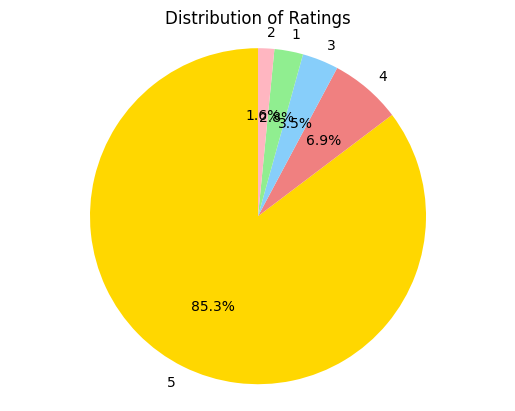

In [30]:
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightpink'])
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.title('Distribution of Ratings')
plt.show()

In [31]:
df1['category'].value_counts()

category
Thời Trang Nam             67694
Túi Ví Nữ                  53775
Giày Dép Nữ                44355
Phụ Kiện & Trang Sức Nữ    39152
Thời Trang Nữ              36168
Giày Dép Nam               26221
Đồng Hồ                    21924
Name: count, dtype: int64

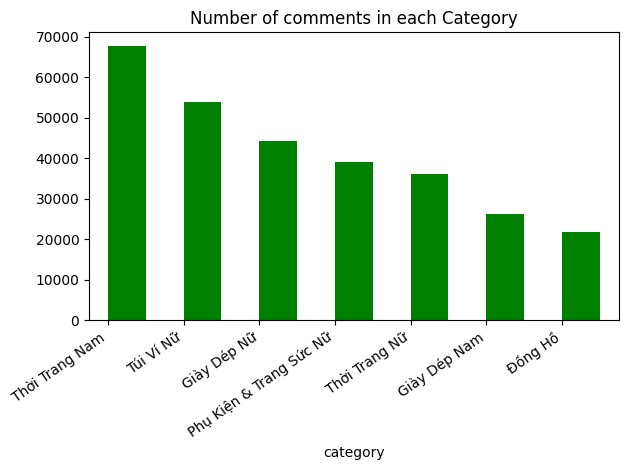

In [36]:
df1['category'].value_counts().plot(kind='bar', legend=False, align='edge',color='green')

plt.title('Number of comments in each Category')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

In [37]:
grouped = df1.groupby('category').agg({'rating': 'mean'})
grouped

,rating
category,
Giày Dép Nam,4.613096
Giày Dép Nữ,4.661932
Phụ Kiện & Trang Sức Nữ,4.679991
Thời Trang Nam,4.709147
Thời Trang Nữ,4.731697
Túi Ví Nữ,4.810079
Đồng Hồ,4.621191


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, 'Đồng Hồ'),
  Text(0.0, 0, 'Giày Dép Nam'),
  Text(1.0, 0, 'Giày Dép Nữ'),
  Text(2.0, 0, 'Phụ Kiện & Trang Sức Nữ'),
  Text(3.0, 0, 'Thời Trang Nam'),
  Text(4.0, 0, 'Thời Trang Nữ'),
  Text(5.0, 0, 'Túi Ví Nữ'),
  Text(6.0, 0, 'Đồng Hồ'),
  Text(7.0, 0, '')])

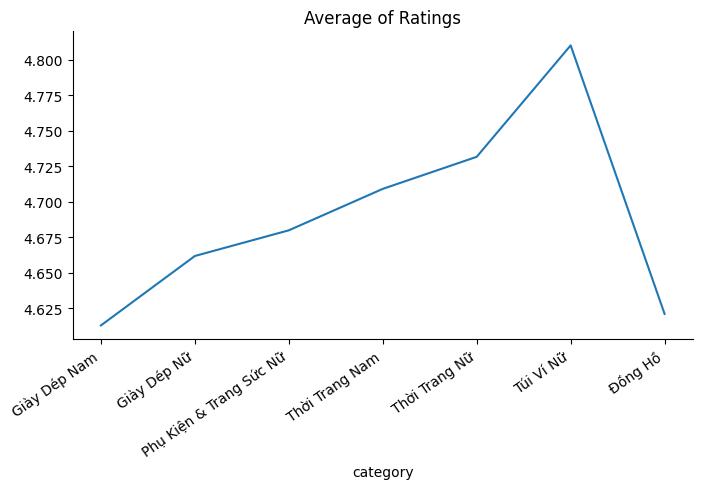

In [38]:
grouped['rating'].plot(kind='line', figsize=(8, 4), title='Average of Ratings')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=35, ha='right')

C:\Users\Quoc Huy\AppData\Local\Temp\ipykernel_16668\793287558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['length'] = df1['processed_comment'].apply(len)


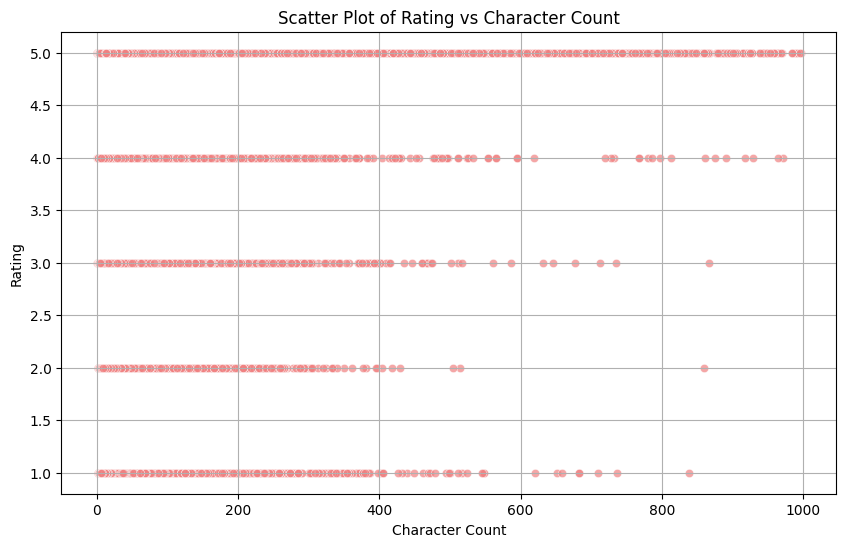

In [39]:
# Biểu diễn số ký tự của các bình luận theo rating

# Đếm số ký tự của từng comment
df1['length'] = df1['processed_comment'].apply(len)
# Giới hạn số ký từ từ 0 đến 1000
filtered_comments = df1[(df1['length'] >= 0) & (df1['length'] <= 1000)]
# Tạo một DataFrame chứa rating và độ dài của comment
data = pd.DataFrame({'rating': df1['rating'], 'length': filtered_comments['length']})

# Vẽ biểu đồ scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='length', y='rating', data=data, color='lightcoral', alpha=0.7)
plt.title('Scatter Plot of Rating vs Character Count')
plt.xlabel('Character Count')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

In [41]:
df1 = df1.drop(columns=['length'])

# Labeling Data

In [32]:
conditions = [
    (df1['rating'] <= 3),
    (df1['rating'] > 3)
]

values = ['neg','pos']

df1['class'] = np.select(conditions, values)
df2 = df1[['category','processed_comment','class']]

df2.reset_index(drop=True, inplace=True)
df2.head()

C:\Users\Quoc Huy\AppData\Local\Temp\ipykernel_4984\930788772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['class'] = np.select(conditions, values)


,category,processed_comment,class
0,Đồng Hồ,đặt hôm_qua nay hàng đồng_hồ siêu đẹp chất_lượ...,pos
1,Đồng Hồ,sản_phẩm chính hãng phiếu bảo_hành tem chống g...,pos
2,Đồng Hồ,xuất_sắc shop confirm đóng_gói hàng nhanh kiểu...,pos
3,Đồng Hồ,săn sale giá hời áp xu quá rẻ đầy_đủ tem chống...,pos
4,Đồng Hồ,đồng_hồ siêu đẹp giao hàng siêu nhanh shop qua...,pos


In [43]:
grouped = df2.groupby(['category', 'class'])['processed_comment'].count().unstack()
grouped

class,neg,pos
category,,
Giày Dép Nam,2641,23580
Giày Dép Nữ,4184,40171
Phụ Kiện & Trang Sức Nữ,3232,35920
Thời Trang Nam,5268,62426
Thời Trang Nữ,2746,33422
Túi Ví Nữ,2370,51405
Đồng Hồ,2148,19776


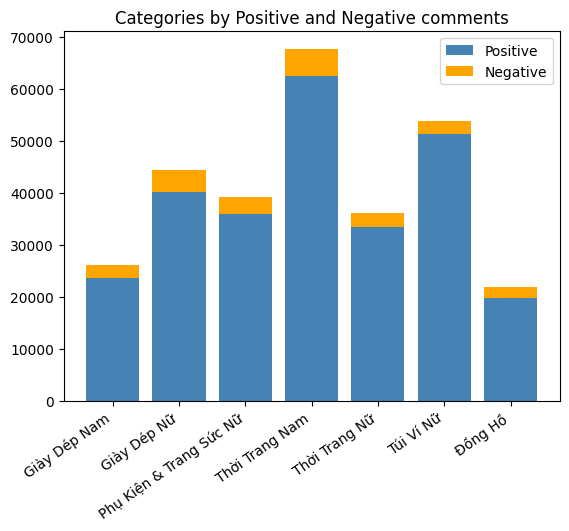

In [44]:
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped['pos'], label='Positive',color='steelblue')
ax.bar(grouped.index, grouped['neg'], bottom=grouped['pos'], label='Negative',color='orange')
ax.set_title('Categories by Positive and Negative comments')
plt.xticks(rotation=35, ha='right')
ax.legend()

C:\Users\Quoc Huy\AppData\Local\Temp\ipykernel_16668\2796740893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['length'] = df2['processed_comment'].apply(len)
C:\Users\Quoc Huy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Quoc Huy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\

<Figure size 1000x700 with 0 Axes>

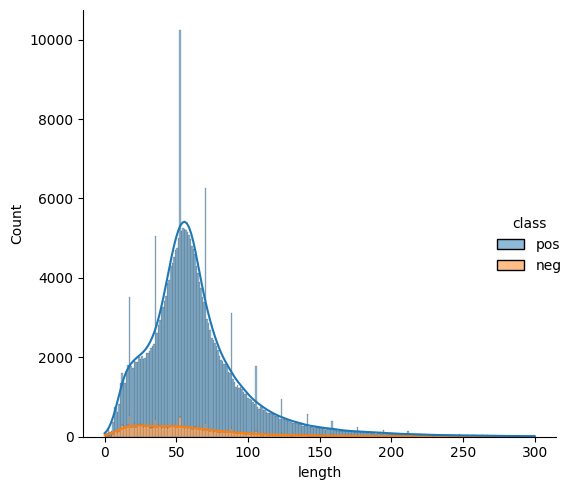

In [46]:
df2['length'] = df2['processed_comment'].apply(len)
filtered_comments = df2[(df2['length'] >= 0) & (df2['length'] <= 300)]
data = pd.DataFrame({'class': df1['class'], 'length': filtered_comments['length']})

plt.figure(figsize=(10, 7))
sns.displot(data=data, x='length', hue='class', multiple='stack', kde=True)
plt.tight_layout()
plt.show()

In [47]:
df_final = df2[['processed_comment','class']]
df_final.to_csv('./data_files/shopee_final.csv',index=False)

# 3. Visualize

In [48]:
df_pos = df1[df1['rating'] > 3]
df_pos.head()

,category,rating,processed_comment,class,length
0,Đồng Hồ,5,đặt hôm_qua nay hàng đồng_hồ siêu đẹp chất_lượ...,pos,149
1,Đồng Hồ,5,sản_phẩm chính hãng phiếu bảo_hành tem chống g...,pos,179
2,Đồng Hồ,5,xuất_sắc shop confirm đóng_gói hàng nhanh kiểu...,pos,203
3,Đồng Hồ,5,săn sale giá hời áp xu quá rẻ đầy_đủ tem chống...,pos,116
4,Đồng Hồ,5,đồng_hồ siêu đẹp giao hàng siêu nhanh shop qua...,pos,74


<Axes: ylabel='category'>

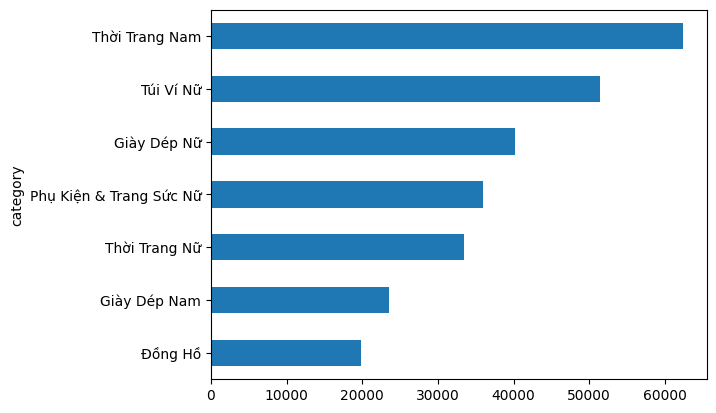

In [49]:
df_pos.category.value_counts().sort_values().plot(kind = 'barh')

In [50]:
# Wordcloud

# Kết hợp nội dung của tất cả các comments thành 1 list
all_comments = ' '.join(df_pos['processed_comment'].tolist())

wc_pos = WordCloud(width=800, height=400, background_color='white')
# generate the word cloud
wc_pos.generate(all_comments)

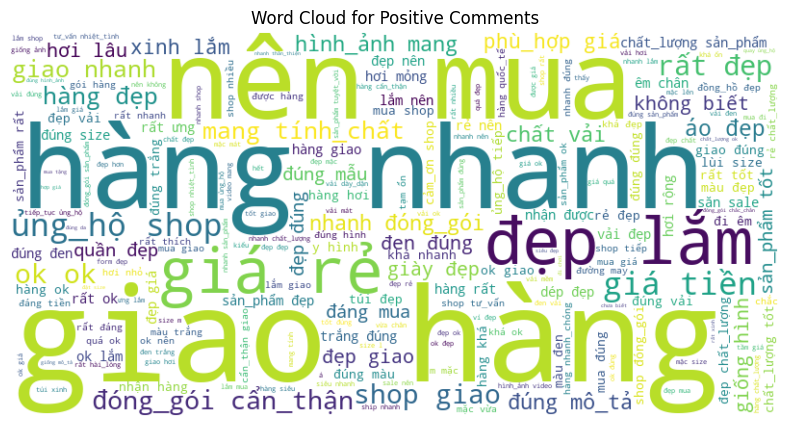

In [51]:
# Show
plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear',)
plt.axis('off')
plt.title('Word Cloud for Positive Comments')
plt.show()

In [33]:
df_neg = df1[df1['rating'] < 4]
df_neg.head()

,category,rating,processed_comment,class
182,Đồng Hồ,1,bóc seal xước tùm_lum shop chịu trách_nhiệm va...,neg
401,Đồng Hồ,1,giao đồng_hồ chạy sai thời_gian,neg
442,Đồng Hồ,2,mặt đồng_hồ rất dễ xước mua đeo cẩn_thận tí xư...,neg
508,Đồng Hồ,1,đẹp đúng mô_tả da đẹp kim giây kẹt kim phút vô...,neg
622,Đồng Hồ,3,da đen hàng đẹp khá bất_ngờ cách đóng_gói hàng...,neg


<Axes: ylabel='category'>

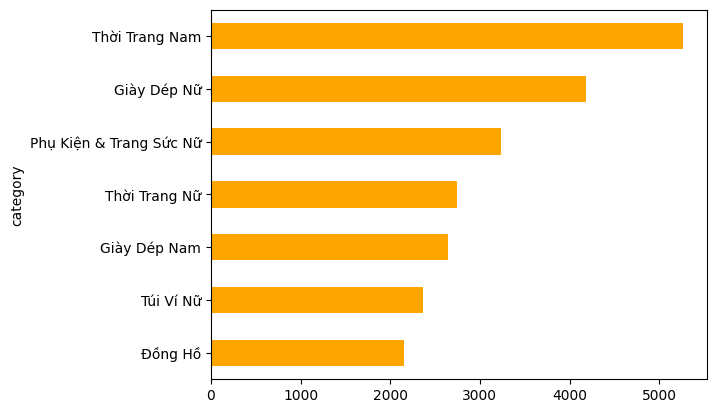

In [35]:
df_neg.category.value_counts().sort_values().plot(kind = 'barh', color='orange')

In [36]:
# Wordcloud

# Kết hợp nội dung của tất cả các comments thành 1 list
all_comments = ' '.join(df_neg['processed_comment'].tolist())

# Tạo wordcloud
wc_neg = WordCloud(width=800, height=400, background_color='white')
# generate the word cloud
wc_neg.generate(all_comments)

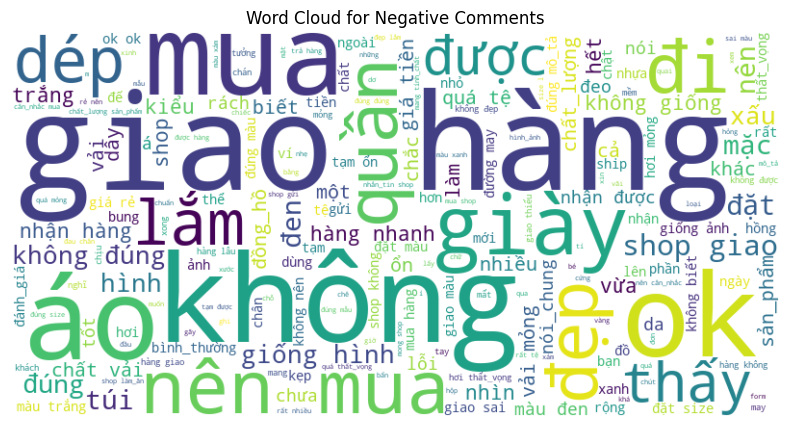

In [37]:
# Show
plt.figure(figsize=(10,5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Comments')
plt.show()